Attempting to load data from: /content/pk_dataset.npz
Data loaded successfully. Total samples: 200
P(k) features (k-bins): 200
Train/Test split: 180 training samples, 20 testing samples.

--- Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,394 (1.02 MB)

 Trainable params: 267,394 (1.02 MB)

 Non-trainable params: 0 (0.00 B)


Training finished after 100 epochs.
Final Training MAE: 0.1498
Final Validation MAE: 0.0704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Test Set Evaluation - MSE: 0.0070, MAE: 0.0655


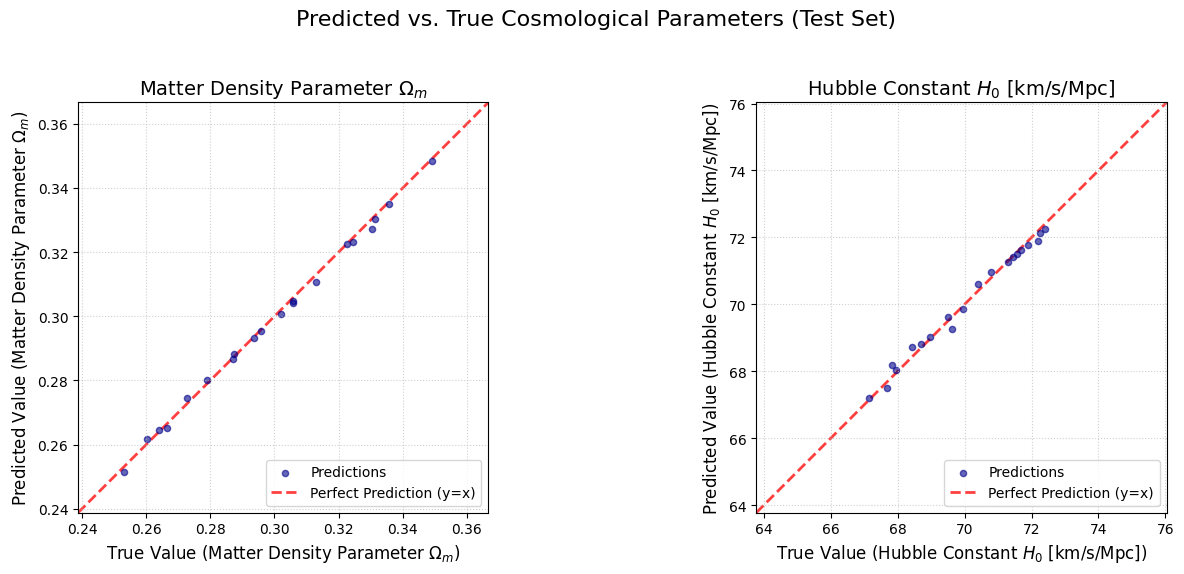

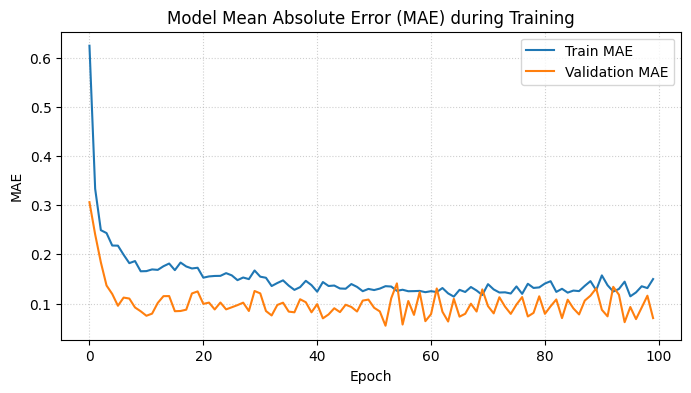

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os


DATA_FILE_PATH = '/content/pk_dataset.npz'

try:
    print(f"Attempting to load data from: {DATA_FILE_PATH}")
    data = np.load(DATA_FILE_PATH)

    # Extract features (P(k)) and targets (parameters)
    X = data['Pk']          # Features: P(k) array (N_samples x N_k)
    Y = data['params']      # Targets: [Omega_m, H_0] array (N_samples x 2)

    print(f"Data loaded successfully. Total samples: {X.shape[0]}")
    print(f"P(k) features (k-bins): {X.shape[1]}")

except FileNotFoundError:
    print("-" * 50)
    print(f"Error: {DATA_FILE_PATH} not found.")
    print("Generating DUMMY DATA for demonstration purposes only.")
    print("Please upload your actual 'pk_dataset.npz' file to Colab.")
    print("-" * 50)

    # Dummy Data Generation (for demonstration if file is missing)
    N_samples = 1000
    N_k = 200
    X = np.random.rand(N_samples, N_k) + np.linspace(1e-4, 1e-1, N_k) # Pk-like data
    Y = np.random.rand(N_samples, 2)
    Y[:, 0] = Y[:, 0] * 0.4 + 0.1  # Omega_m roughly in [0.1, 0.5]
    Y[:, 1] = Y[:, 1] * 20 + 60    # H0 roughly in [60, 80]



# The power spectrum P(k) spans many orders of magnitude.
# A logarithmic transformation is essential for numerical stability.
X_log = np.log10(X)

# Standardize the features (input P(k) data)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_log)

# Standardize the targets (cosmo parameters) for faster training.
# This will be inverse-transformed later for plotting.
scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y)

X_train, X_test, Y_train_scaled, Y_test_scaled, Y_train, Y_test = train_test_split(
    X_scaled, Y_scaled, Y, test_size=0.1, random_state=42
)

print(f"Train/Test split: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples.")

input_dim = X_train.shape[1] # N_k, the number of k-bins
output_dim = Y_train.shape[1] # 2, for Omega_m and H0

model = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(output_dim, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    # Mean Squared Error  is the standard loss for regression problems
    loss='mse',
    metrics=['mae'] # Mean Absolute Error is a clearer performance metric
)

print("\n--- Model Summary ---")
model.summary()

# Training the model
history = model.fit(
    X_train, Y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.1, # 10% of training data for validation
    verbose=0
)

print(f"\nTraining finished after {len(history.epoch)} epochs.")
print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")


Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions back to the original parameter units
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)

loss, mae = model.evaluate(X_test, Y_test_scaled, verbose=0)
print(f"Test Set Evaluation - MSE: {loss:.4f}, MAE: {mae:.4f}")

param_names = ['Matter Density Parameter $\\Omega_m$', 'Hubble Constant $H_0$ [km/s/Mpc]']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Predicted vs. True Cosmological Parameters (Test Set)', fontsize=16)

def plot_results(ax, true_values, pred_values, param_name):
    ax.scatter(true_values, pred_values, alpha=0.6, s=20, label='Predictions', color='darkblue')

    min_val = min(true_values.min(), pred_values.min())
    max_val = max(true_values.max(), pred_values.max())
    lims = [min_val * 0.95, max_val * 1.05]

    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction (y=x)', linewidth=2)

    ax.set_title(param_name, fontsize=14)
    ax.set_xlabel(f'True Value ({param_name})', fontsize=12)
    ax.set_ylabel(f'Predicted Value ({param_name})', fontsize=12)
    ax.legend(loc='lower right')
    ax.grid(True, ls=':', alpha=0.6)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

# Plot Omega_m results
plot_results(axes[0], Y_test[:, 0], Y_pred[:, 0], param_names[0])

# Plot H0 results
plot_results(axes[1], Y_test[:, 1], Y_pred[:, 1], param_names[1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE) during Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, ls=':', alpha=0.6)
plt.show()